## This notebook uses geopandas to play with the NYC neighborhoods shapefile available at https://www1.nyc.gov/site/planning/data-maps/open-data/bytes-archive.page. It also maps crimes to neighborhoods for the subset of the data belonging to Brooklyn.

Please note: We are mapping to neighborhoods locally, using this notebook, instead of using Big Data techniques because of compatibility issues between the versions of Python available on Dumbo and the geopandas package.

## Before running this notebook, please install the geopandas package. The easiest way to do so is to follow these steps:
1. Download and install Anaconda from https://www.continuum.io/downloads
2. Installing geopandas from conda-forge by running

    conda install -c conda-forge geopandas

In [1]:
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import io
import re
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
pd.options.display.max_rows = 10

## Before running this notebook, please download and unzip the three folders available at https://github.com/zeynepsebnem/ds1004-big-data-project/tree/master/data/bk_slice.

In [2]:
# Then change this variable to the file location:
dataloc = 'C:/Users/Julie/Desktop'

In [3]:
# Load our shapefile using geopandas
neighborhoods = geopandas.read_file('nynta.shp')
display(neighborhoods)

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.228028,"POLYGON ((990897.9000244141 169268.1207885742,..."
1,4,Queens,081,QN52,East Flushing,2.945438e+07,25843.364923,"POLYGON ((1041061.948242188 215429.4609985352,..."
2,4,Queens,081,QN48,Auburndale,3.416422e+07,32446.878753,"POLYGON ((1046392.971191406 210169.7536010742,..."
3,4,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904732,"POLYGON ((1038593.459228516 221913.3550415039,..."
4,4,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712112,"POLYGON ((1022728.275024414 217530.8082275391,..."
...,...,...,...,...,...,...,...,...
190,1,Manhattan,061,MN36,Washington Heights South,2.310048e+07,22095.210900,"POLYGON ((1003231.182189941 248025.8281860352,..."
191,2,Bronx,005,BX26,Highbridge,1.645722e+07,18507.423648,"POLYGON ((1007134.753601074 247182.4255981445,..."
192,2,Bronx,005,BX63,West Concourse,1.938664e+07,28550.756378,"POLYGON ((1008620.929199219 246511.2341918945,..."
193,2,Bronx,005,BX09,Soundview-Castle Hill-Clason Point-Harding Park,5.199039e+07,67346.087026,"(POLYGON ((1017313.476196289 237489.665222168,..."


In [4]:
# Find the boundary of each neighborhood (just for fun)
bounds = neighborhoods.bounds
display(bounds)

,minx,miny,maxx,maxy
0,9.822082e+05,162478.111633,9.917731e+05,174107.999390
1,1.033886e+06,211169.669617,1.041164e+06,216737.932434
2,1.040414e+06,208318.344421,1.046393e+06,220023.060791
3,1.032285e+06,215407.440186,1.042341e+06,223347.718994
4,1.018490e+06,214963.454590,1.024560e+06,220477.852600
...,...,...,...,...
190,9.980431e+05,241841.070435,1.003231e+06,249664.240417
191,1.002623e+06,241003.934814,1.007441e+06,247284.540405
192,1.002772e+06,235572.969604,1.008621e+06,247186.574219
193,1.016247e+06,232396.226196,1.029605e+06,241334.257385


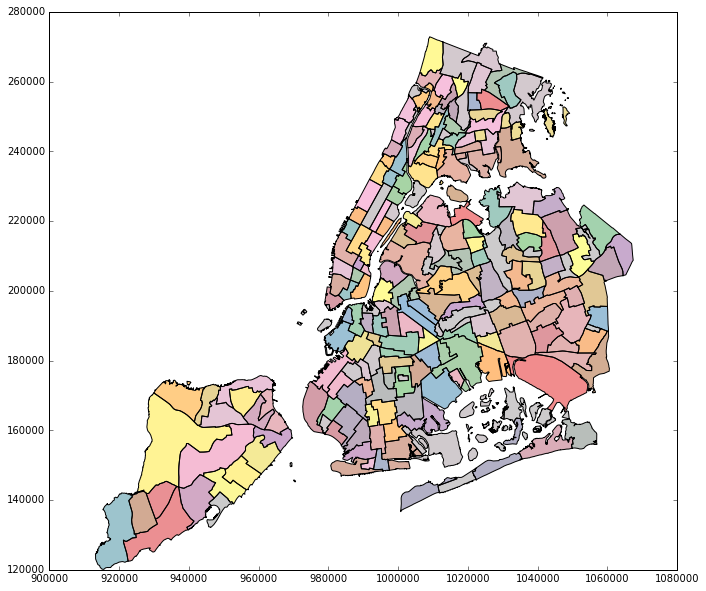

In [5]:
# Draw a map of all the neighborhoods (also just for fun)
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
neighborhoods.plot(column='NTAName', legend=False, ax=ax)
plt.show()

In [ ]:
# Map crimes to neighborhoods
def find_neighborhood(x_coord, y_coord):
    '''
    Takes a pair of X and Y coordinates (using the NAD_1983_StatePlane_New_York_Long_Island coordinate system)
    and returns the corresponding New York City neighborhood.
    '''
    if np.isnan(x_coord) or np.isnan(y_coord):
        return np.nan
    
    point = Point(x_coord, y_coord)
    matches = neighborhoods.geometry.contains(Point(x_coord, y_coord))
    
    if any(matches):
        return neighborhoods.loc[matches, 'NTAName'].values[0]
    
    return np.nan

In [ ]:
years = range(2006, 2016)

for crime_type in ['felony', 'misdemeanor', 'violation']:
    for year in years:
        # Define filename
        folder = dataloc + '/bk_slice_' + crime_type + '/'
        filename = folder + crime_type + '_{}_desc_year_borough'.format(year)
        
#         # Add filenames here if you'd like to skip any
#         if filename in []:
#             continue
        
        print('Beginning filename '+filename) # Just to keep track of progresss
        
        # Define regular expressions so that we can correctly parse columns with commas in them
        latlong_regex = re.compile(r'(\([^\(\)]+\))')
        unclassified_regex = re.compile(r',([^0-9]*,UNCLASSIFIE),')
        gambling_regex = re.compile(r',(LOITERING\/GAMBLING \(.*),BROOKLYN')
        
        # Replace parentheses with quotes and pipe into file-like object
        # Adapted from an answer to this StackOverflow question:
        # http://stackoverflow.com/questions/35948417/how-to-use-square-brackets-as-a-quote-character-in-pandas-read-csv
        with io.open(filename+'.out', 'rb') as fin:
            fo = io.StringIO()
            fo.writelines(unicode(re.sub(gambling_regex,
                                         r',"\1",BROOKLYN',
                                         re.sub(unclassified_regex,
                                                r',"\1",',
                                                re.sub(latlong_regex, r'"\1"', line))))
                                  for line in fin)
            fo.seek(0)

        # Read transformed CSV into dataframe
        crimes = pd.read_csv(fo, index_col=None, header=None, quotechar='"')

        # Drop any rows that are missing x or y coordinates
        crimes = crimes[~pd.isnull(crimes[6])]
        crimes = crimes[~pd.isnull(crimes[7])]
        
        # Find the neighborhood for each crime
        crimes.insert(len(crimes.columns.values), len(crimes.columns.values),
              crimes.apply(lambda row: find_neighborhood(row[6], row[7]), axis=1))
        
        crimes.to_csv(filename+'_with_hood.out', index=False, header=False)